In [1]:
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from openml import datasets, tasks, flows, config
from sklearn import linear_model
from openmlstudy14.preprocessing import ConditionalImputer
from workloadoptimization.essentials import Component, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
from workloadoptimization.openml_helper import OpenMLReader
from workloadoptimization.search_space import SearchSpaceDesigner
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [2]:
flow_ids = [5981] # Random forsst with warmstarting
task_ids = [31]

In [3]:
# load the dataset
task = tasks.get_task(task_id=31)
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [4]:
def extract_experiments(file_path, task_ids, flow_ids):
    openMLReader = OpenMLReader()
    if os.path.isfile(file_path):
        return pd.read_pickle(file_path)
    frames = []
    for t in task_ids:
        for f in flow_ids:
            frames.append(openMLReader.getTopRuns(-1, f, t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(file_path)
    return Experiments


# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extract_experiments('meta/hyper-opt-experiment-31-5981', task_ids, flow_ids)
Experiments = Experiments[Experiments.flow_id == flow_ids]

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([('dualimputer', ConditionalImputer()),
                                ('standardscaler', StandardScaler()),
                                ('logisticregression', LogisticRegression())])

In [6]:
# The openml api is not backward compatible for this specific pipeline (5981), so we are recreating it in scikit learn
OPENML_FLOWS = {5981: pipeline}
parser = ExperimentParser()
experimentObjects = parser.extract_sklearn_pipelines(Experiments, OPENML_FLOWS)

In [7]:
# load the dataset
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices, test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute,
    return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [8]:
def objective(pipeline, params):
    print '.',
    # seems when tol is big (greater than 1) scikit learn throws an exception
    # I couldn't find a way to cap a value in the search space of hyperopt, 
    # this is the alternative solution
    # if params['classifier__tol'] > 0.2:
    #    params['classifier__tol'] = 0.2
    pipeline.set_params(**params)
    #print pipeline.steps
    pipeline.fit(X_train, y_train)
    #    print 'Error for the params: {}'.format(params)
    accuracy = pipeline.score(X_test, y_test)
    # print 'accuracy = {}'.format(accuracy)
    return 1 - accuracy

In [9]:
for k in experimentObjects[0].extractParams().keys():
    if not k.startswith('logisticregression'):
        a = []
        for e in experimentObjects:
            a.append(e.extractParams()[k])
        print(k, [[x, a.count(x)] for x in set(a)])


('standardscaler__with_mean', [[True, 11]])
('standardscaler__copy', [[True, 11]])
('standardscaler__with_std', [[True, 11]])


In [29]:
import copy
import warnings

warnings.filterwarnings('ignore')
baseline = []
iter_baseline = []
pipeline = Pipeline([('dualimputer', ConditionalImputer()),
                     ('standardscaler', StandardScaler()),
                     ('logisticregression', LogisticRegression())])
# Baseline 
for e in experimentObjects:
    start = time.time()
    params = e.extractParams()
    params['logisticregression__tol'] = 1e-16
    params['logisticregression__warm_start'] = False
    params['logisticregression__solver'] = 'saga'
    params['logisticregression__dual'] = False
    params['logisticregression__max_iter'] = 10000
    quality = objective(pipeline, params)
    # print pipeline.steps[2][1].warm_start
    #print params['logisticregression__max_iter'], pipeline.steps[2][1].n_iter_
    end = time.time()
    time_to_converge_baseline = end - start
    baseline.append(time_to_converge_baseline)
    iter_baseline.append(pipeline.steps[2][1].n_iter_[0])


.

 .

 . .

 . .

 .

 . .

 .

 .


In [30]:
# Optimized
# reinitialize the pipeline (model parameters)
pipeline = Pipeline([('dualimputer', ConditionalImputer()),
                     ('standardscaler', StandardScaler()),
                     ('logisticregression', LogisticRegression())])
optimized = []
iter_optimized = []
best_pipeline = copy.deepcopy(pipeline)
best_quality = 0.0
for e in experimentObjects:
    start = time.time()
    params = e.extractParams()
    params['logisticregression__tol'] = 1e-16
    params['logisticregression__warm_start'] = True
    params['logisticregression__solver'] = 'saga'
    params['logisticregression__dual'] = False
    params['logisticregression__max_iter'] = 10000
    # warm start the model to the best existing model
    pipeline = copy.deepcopy(best_pipeline)
    quality = objective(pipeline, params)
    # print params['logisticregression__max_iter'], pipeline.steps[2][1].n_iter_
    end = time.time()
    time_to_converge = end - start
    optimized.append(time_to_converge)
    iter_optimized.append(pipeline.steps[2][1].n_iter_[0])
    # if the quality of the new model is better existing best model
    # replace the best model with the existing model
    if quality > best_quality:
        print ('changing the best model %', quality) 
        best_quality = quality
        best_pipeline = copy.deepcopy(pipeline)


. ('changing the best model %', 0.30000000000000004)
.

 .

 .

 . .

 . .

 .

 . .

In [38]:
import numpy

result = pd.DataFrame.from_dict({'method': ['optimized', 'baseline'],
                                 'time': [numpy.mean(optimized), numpy.mean(baseline)],
                                 'num_iterations': [numpy.mean(iter_optimized), numpy.mean(iter_baseline)]})


Text(0.5,1,u'Pipeline 5981 (LogisticRegression with SGD), 11 Executions')

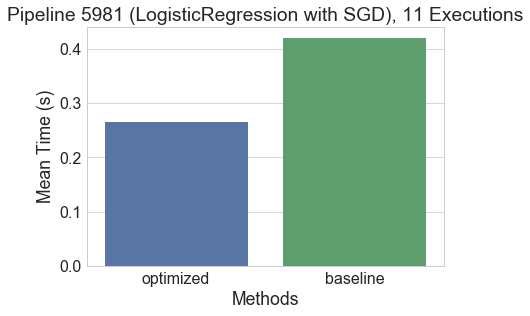

In [42]:
ax = sns.barplot(x='method', y='time', data=result)
ax.set_xlabel('Methods')
ax.set_ylabel('Mean Time (s)')
ax.set_title('Pipeline 5981 (LogisticRegression with SGD), 11 Executions')

Text(0.5,1,u'Pipeline 5981 (LogisticRegression with SGD), 11 Executions')

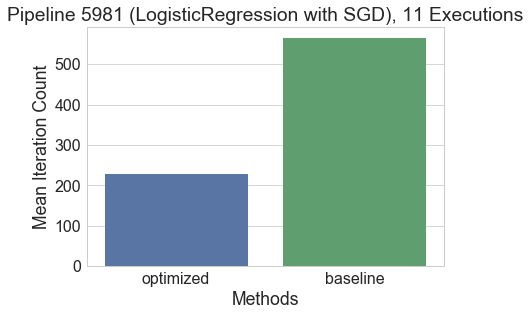

In [41]:
ax = sns.barplot(x='method', y='num_iterations', data=result)
ax.set_xlabel('Methods')
ax.set_ylabel('Mean Iteration Count')
ax.set_title('Pipeline 5981 (LogisticRegression with SGD), 11 Executions')